# Neutralization assays of HAARVI sera versus WT and mutant spike-pseudotyped lentiviruses

Andrea (with some help from me) cloned these mutants and she made spike-PV lentivirus. 
Andrea set up most of the neuts, with help from me on a few things here and there. 

She started each sample at a slightly different initial dilution to capture the full neutralization curve for each sample, given that each serum has a different neutralization potency (determined in Kate's original paper).

The data that are analyzed in this notebook were pre-processed by Kate's `excel_to_fracinfect` script. 

### Import modules

In [1]:
import itertools
import math
import os
import warnings

from IPython.display import display, HTML
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from plotnine import *

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import yaml

In [2]:
warnings.simplefilter('ignore')

In [3]:
plt.style.use('seaborn-white')
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))
#theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))

### Create results directory

In [4]:
resultsdir='mutant_neuts_results/'
os.makedirs(resultsdir, exist_ok=True)

Read config file

In [5]:
with open('mutant_neuts_config.yaml') as f:
    config = yaml.safe_load(f)

### Read in data
* Concatenate the `frac_infectivity` files.
* Remove samples specified in config file. 
* Also remove specified sample / dilution combinations where something has clearly gone wrong experimentally (like forgetting to add virus or cells). 
* Replace `serum` with `display_name`

In [6]:
frac_infect = pd.DataFrame() # create empty data frame

if config['neut_samples_ignore']:
    neut_samples_ignore = config['neut_samples_ignore']

for f in config['neut_input_files'].keys():
    df = (pd.read_csv(f, index_col=0).assign(date=config['neut_input_files'][f]))
    frac_infect = frac_infect.append(df).reset_index(drop=True)

print(f"Length before dropping anything = {len(frac_infect.index)}")
    
frac_infect = (frac_infect
#         .query('serum not in @neut_samples_ignore') # currently none in config
        .replace({'serum' : config['display_names']})
        .reset_index(drop=True)
       )

print(f"Length after dropping neut_samples_ignore = {len(frac_infect.index)}")

# below deals with samples / dates/ dilutions to ignore, which are currently none

# for s in config['neut_ignore_dilutions']:
#     dil = config['neut_ignore_dilutions'][s]
#     l = len((frac_infect[(frac_infect['serum'] == s) & (frac_infect['concentration'] == dil)]))
#     print(f"Dropping {l} rows")
#     frac_infect = frac_infect.drop(frac_infect[((frac_infect['serum'] == s) & (frac_infect['concentration'] == dil))].index)
#     print(f"Length after dropping {s}: {dil} = {len(frac_infect.index)}")

# for s in config['neut_ignore_dates']:
#     dat = config['neut_ignore_dates'][s]
#     l = len((frac_infect[(frac_infect['serum'] == s) & (frac_infect['date'] == dat)]))
#     print(f"Dropping {l} rows")
#     frac_infect = frac_infect.drop(frac_infect[((frac_infect['serum'] == s) & (frac_infect['date'] == dat))].index)
#     print(f"Length after dropping {s}: {dil} = {len(frac_infect.index)}")

frac_infect.head(2)

Length before dropping anything = 1176
Length after dropping neut_samples_ignore = 1176


,serum,virus,replicate,concentration,fraction infectivity,date
0,1C_d26,WT,1,0.025000,0.005157,201106
1,1C_d26,WT,1,0.008333,0.042560,201106


### Use `neutcurve` to fit Hill curves to data.
Get IC50 and calculate NT50. 
Determine if IC50 is bound.

In [7]:
for d in frac_infect['date'].unique():
    print(d)

201106
201116
201119
201221


In [8]:
fitparams = pd.DataFrame(columns=['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'date'])

for d in frac_infect['date'].unique():
    fits = neutcurve.CurveFits(frac_infect.query('date==@d'))

    fp = (
        fits.fitParams()
        .assign(NT50=lambda x: 1/x['ic50'],
                date=d
               )
        .replace({'WT':'wildtype'})
        # get columns of interest
        [['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'date']] 
        )

    # couldn't get lambda / conditional statement to work with assign, so try it here:
    fp['ic50_is_bound'] = fp['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)
    fitparams=fitparams.append(fp, ignore_index=True)

fitparams.head()

,serum,virus,ic50,NT50,ic50_bound,date,ic50_is_bound
0,1C_d26,wildtype,0.000600,1666.929235,interpolated,201106,False
1,1C_d26,F456K,0.000871,1148.676778,interpolated,201106,False
2,1C_d26,E484P,0.002929,341.449922,interpolated,201106,False
3,1C_d113,wildtype,0.002278,438.988101,interpolated,201106,False
4,1C_d113,F456K,0.000863,1158.774452,interpolated,201106,False


### Calculate fold change for each mutant relative to wild type.

In [9]:
foldchange = (
    fitparams
    .query('virus != "wildtype"')
    .rename(columns={'virus': 'mutant'})
    .merge(fitparams.query('virus == "wildtype"')
                    [['serum', 'ic50', 'date']]
                    .rename(columns={'ic50': 'wildtype_ic50'}),
           on=['serum', 'date'],
           how='left',
           validate='many_to_one',
           )
    .assign(fold_change=lambda x: x['ic50'] / x['wildtype_ic50'],
            log2_fold_change=lambda x: np.log(x['fold_change']) / np.log(2))
    )

foldchange.to_csv(f'{resultsdir}/mutants_foldchange_ic50.csv', index=False)
foldchange

,serum,mutant,ic50,NT50,ic50_bound,date,ic50_is_bound,wildtype_ic50,fold_change,log2_fold_change
0,1C_d26,F456K,0.000871,1148.676778,interpolated,201106,False,0.000600,1.451173,0.537220
1,1C_d26,E484P,0.002929,341.449922,interpolated,201106,False,0.000600,4.881914,2.287447
2,1C_d113,F456K,0.000863,1158.774452,interpolated,201106,False,0.002278,0.378838,-1.400346
3,1C_d113,E484P,0.004507,221.895200,interpolated,201106,False,0.002278,1.978358,0.984303
4,24C_d32,F456K,0.000080,12569.984770,interpolated,201106,False,0.000112,0.711198,-0.491677
5,24C_d32,E484P,0.004713,212.200684,interpolated,201106,False,0.000112,42.128730,5.396733
6,24C_d104,F456K,0.000347,2881.544091,interpolated,201106,False,0.000556,0.624273,-0.679750
7,24C_d104,E484P,0.007323,136.564614,interpolated,201106,False,0.000556,13.172307,3.719436
8,25_d18,G446V,0.000788,1268.659070,interpolated,201116,False,0.000024,32.489495,5.021901
9,25_d94,G446V,0.004655,214.839744,interpolated,201116,False,0.001858,2.505337,1.325005


### Plot the raw neutralization curves

Saving to ./mutant_neuts_results//201116_mab_mutant_neuts.pdf
Saving to ./mutant_neuts_results//201106_sera_mutant_neuts.pdf
Saving to ./mutant_neuts_results//201116_sera_mutant_neuts.pdf
Saving to ./mutant_neuts_results//201119_sera_mutant_neuts.pdf
Saving to ./mutant_neuts_results//201221_sera_mutant_neuts.pdf
Curves not plotted for []


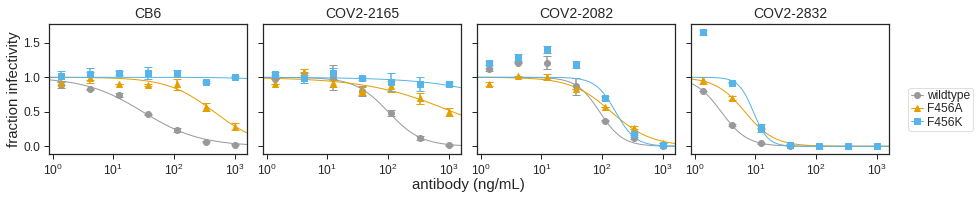

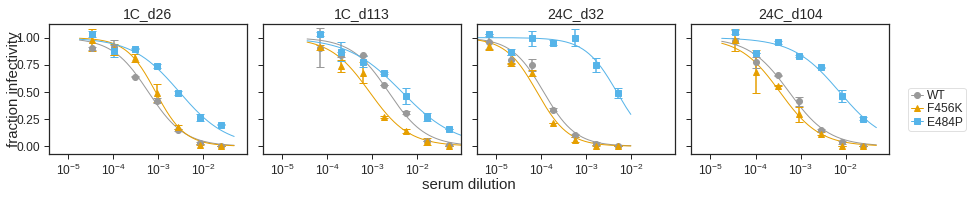

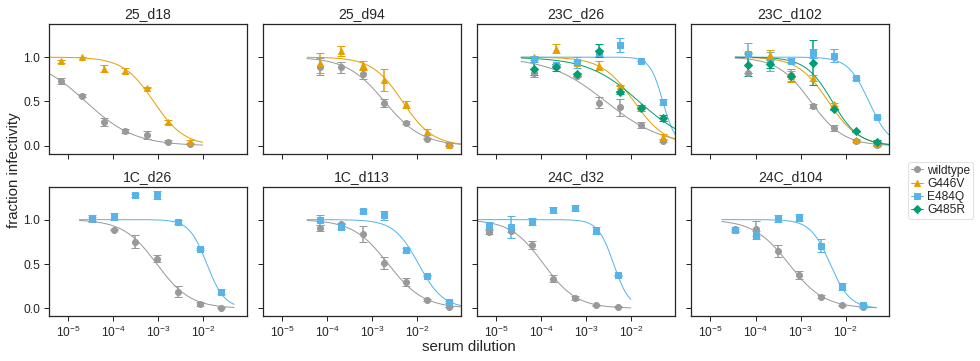

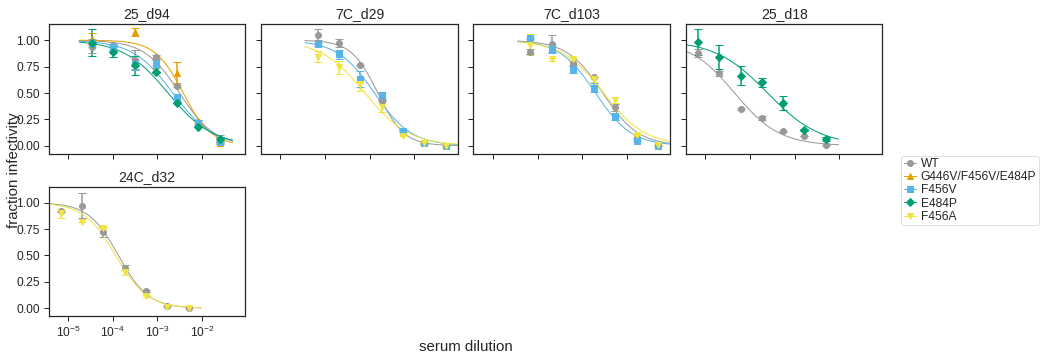

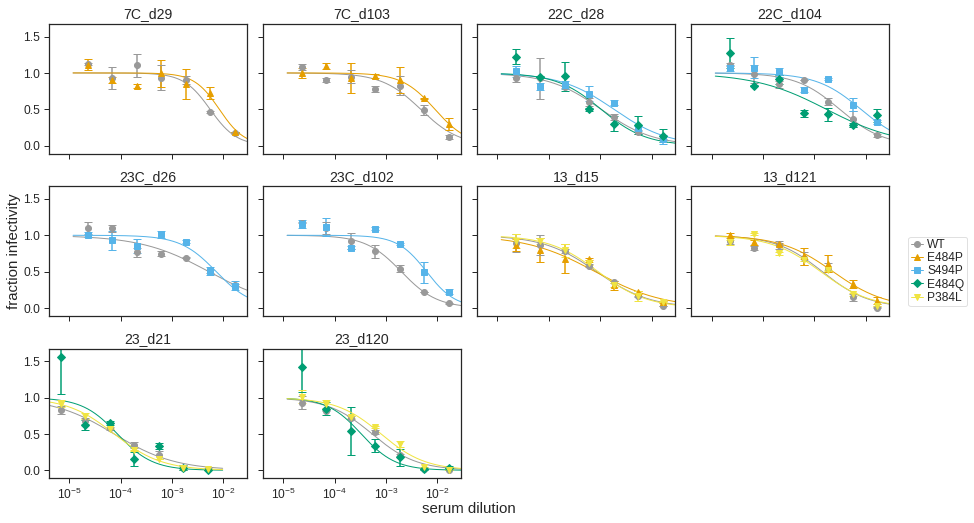

In [10]:
plotted_sera=[] # empty list we will use as a check to make sure we plot everything! 

for plot_grp in [config['antibody_controls'], config['serum_samples']]:
    for d in frac_infect['date'].unique():
        fits = neutcurve.CurveFits(frac_infect.query('date==@d & serum in @plot_grp'))
        xlab= 'antibody (ng/mL)' if plot_grp==config['antibody_controls'] else 'serum dilution'
        name= 'mab' if plot_grp==config['antibody_controls'] else 'sera'
        plotted_sera=plotted_sera + [s for s in plot_grp if s in fits.sera]
        
        if len([s for s in plot_grp if s in fits.sera])>=1:
            fig, axes = fits.plotSera(xlabel=xlab)

            plotfile = f'./{resultsdir}/{d}_{name}_mutant_neuts.pdf'
            print(f"Saving to {plotfile}")
            fig.savefig(plotfile, bbox_inches='tight')

excluded_sera = [s for s in fitparams['serum'] if s not in plotted_sera]
print(f"Curves not plotted for {excluded_sera}")

### Plot fold-change IC50 relative to wild type for each mutant.
You could also imagine drawing a dashed line with the fold-change with RBD depletion, which sets an upper limit on what we would expect to see (the max drop in NT50 we could see due to anything RBD-related). 

To do this you would need to:
* Read in foldchange IC50 due to RBD depletion (specify path in config file)
* Merge with mutant `foldchange` dataframe
* Add `geom_hline` with depletion foldchange

In [11]:
depletion_fc = (pd.read_csv(config['rbd_depletion_foldchange'])
                .rename(columns={'fold_change':'depletion_fc'})
               )

published_data = (pd.read_csv(config['published_metadata'], 
                              dtype={'Days Post-Symptom Onset': int}, 
                              index_col=0)
                  .assign(PID_date = lambda x: x['Participant ID'] + '_d' + x['Days Post-Symptom Onset'].astype(str),
                          PID=lambda x: x['Participant ID'].astype(str),
                          dPSO=lambda x: x['Days Post-Symptom Onset'].astype(int)
                         )
                 )

published_data['dPSO_group'] = (published_data['dPSO']
                                  .apply(lambda x: 'early' if x<=45 else 'late')
                                 )

foldchange = (foldchange.merge(depletion_fc[['serum', 'depletion_fc']],
                               on=['serum'],
                               how='left',
                               validate='many_to_one'
                              )
              .merge(published_data,
                     how='left',
                     left_on='serum',
                     right_on='PID_date'
                    )
             )

foldchange.head()

FileNotFoundError: [Errno 2] No such file or directory: 'results/rbd_depletion_foldchange_ic50.csv'

In [ ]:
plot_sera = config["serum_samples"]
excluded_sera=[s for s in foldchange['serum'] if s not in plot_sera]
print(f'Not plotting results for {excluded_sera}')

p = (ggplot(foldchange
            .query("serum in @plot_sera")
            ) +
     aes('mutant', 'fold_change', 
        ) +
     geom_point(size=2.5) +
     scale_y_log10(name='fold change IC50') +
     facet_grid('dPSO_group~PID', scales='free_x') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(1.5 * foldchange['mutant'].nunique(), 2.5),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(aes(yintercept='depletion_fc'),
                color=CBPALETTE[3],
                alpha=0.7,
                size=1,
                linetype='dotted',
               ) +
     scale_color_manual(values=CBPALETTE[1:],
                        name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/fold_change_IC50_earlylate.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Create plot just for antibody controls here:

In [ ]:
 upper_bound = (
    foldchange
    .query('ic50_bound == "lower"')
    [['serum', 'fold_change']]
    .drop_duplicates()
    )
assert len(upper_bound) == upper_bound['serum'].nunique()

antibody_controls = config['antibody_controls']

p = (ggplot(foldchange
            .query("serum in @antibody_controls")
            .assign(ic50_is_bound=lambda x: x['ic50_is_bound'],
                    )
            ) +
     aes('mutant', 'fold_change', color='ic50_is_bound') +
     geom_point(size=2.5) +
     scale_y_log10(name='fold change IC50') +
     facet_grid('~serum', scales='free') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.5 * foldchange['mutant'].nunique(), 1.25),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(data=upper_bound,
                mapping=aes(yintercept='fold_change'),
                color=CBPALETTE[2],
                alpha=0.7,
                size=1,
                linetype='dotted',
                ) +
     scale_color_manual(values=CBPALETTE[1:],
                        name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/fold_change_IC50_antibodies.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Now plot everything altogether

In [ ]:
upper_bound = (
    foldchange
    .query('ic50_bound == "lower"')
    [['serum', 'fold_change']]
    .drop_duplicates()
    )
assert len(upper_bound) == upper_bound['serum'].nunique()

ncol=min(8, foldchange['serum'].nunique())
nrow= math.ceil(foldchange['serum'].nunique() / ncol)

p = (ggplot(foldchange
            .assign(ic50_is_bound=lambda x: x['ic50_is_bound'],
                    )
            ) +
     aes('mutant', 'fold_change', color='ic50_is_bound') +
     geom_point(size=2.5) +
     scale_y_log10(name='fold change IC50') +
     facet_wrap('~serum', scales='free_x', ncol=ncol,) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(ncol*1.25, foldchange['serum'].nunique()*0.25),
           subplots_adjust={'hspace':0.75}
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(data=upper_bound,
                mapping=aes(yintercept='fold_change'),
                color=CBPALETTE[2],
                alpha=0.7,
                size=1,
                linetype='dotted',
                ) +
     geom_hline(aes(yintercept='depletion_fc'),
                color=CBPALETTE[3],
                alpha=0.7,
                size=1,
                linetype='dotted',
               ) +
     scale_color_manual(values=CBPALETTE[1:],
                        name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/fold_change_IC50.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)